# Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season (S1:JAN-FEB-MAR, S2:APR,MAY,JUN, S3:JUL,AUG,SEP, S4:OCT,NOV,DEC) in which a purchase was made, test the network and plot the results for each class.
<!-- ![Walmart](https://raw.githubusercontent.com/Masterx-AI/Project_Retail_Analysis_with_Walmart/main/Wallmart1.jpg) -->


### Importing libraries

In [1]:
!pip install numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib inline

### Importing dataset

Link: https://www.kaggle.com/datasets/yasserh/walmart-dataset/input

In [3]:
import os
# Make sure to upload the data in colab
# Importing our dataset
df = pd.read_csv("Walmart.csv")
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


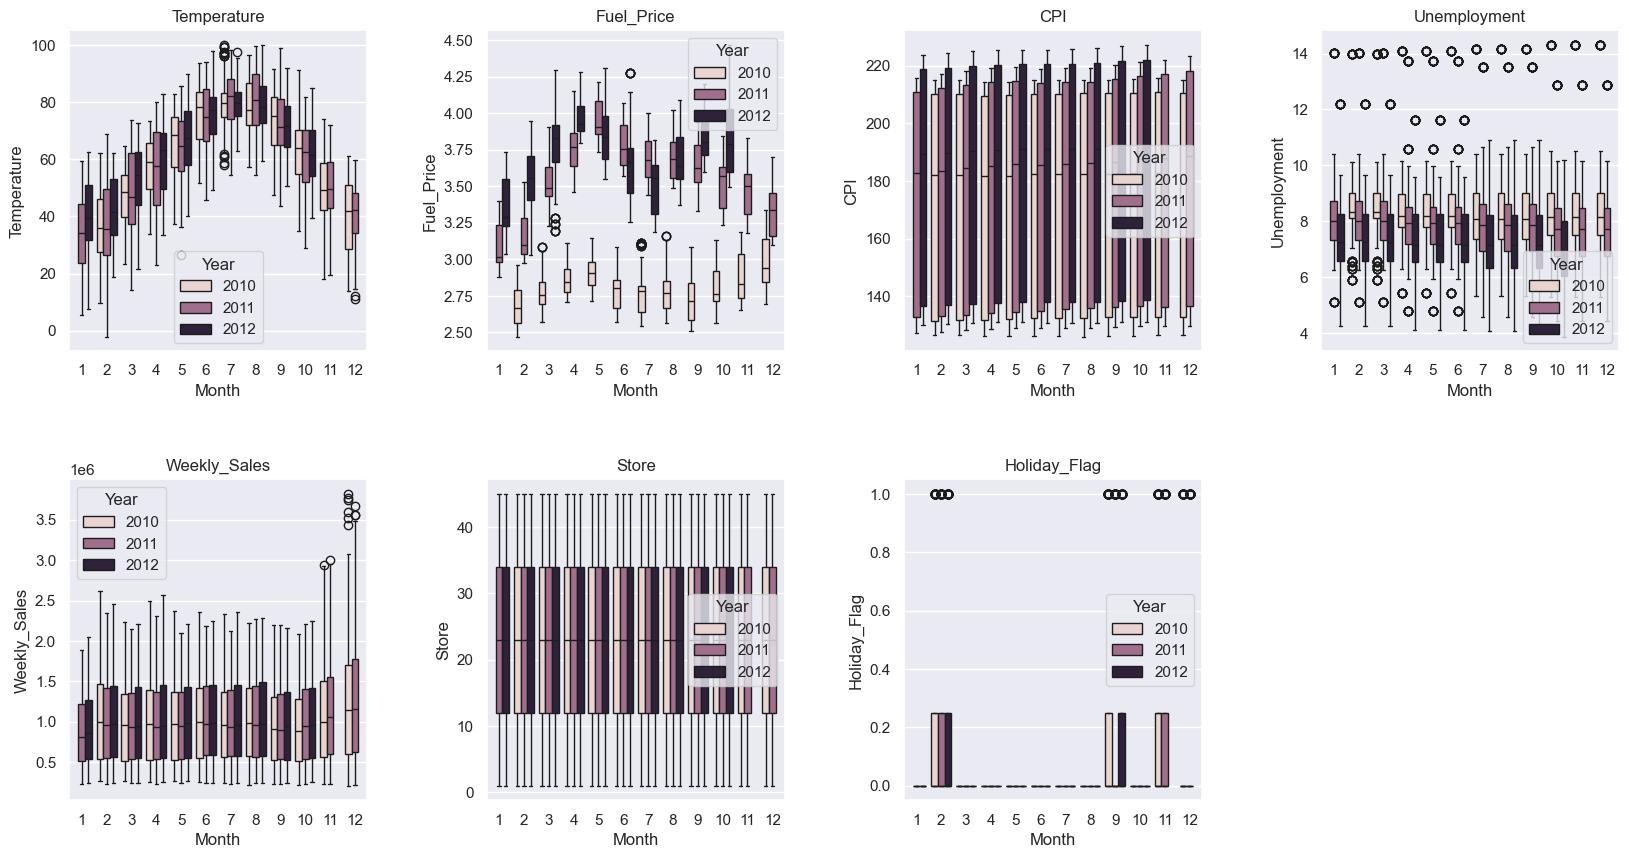

In [ ]:
# Visualize the distribution of each feature by year

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Store', 'Holiday_Flag']):
  sns.boxplot(x='Month', y=column, hue='Year', data=df, ax=axs[i])
  axs[i].set_title(f'{column}')
  axs[i].set_xlabel('Month')
  axs[i].set_ylabel(column)

fig.delaxes(axs[-1])
plt.show()

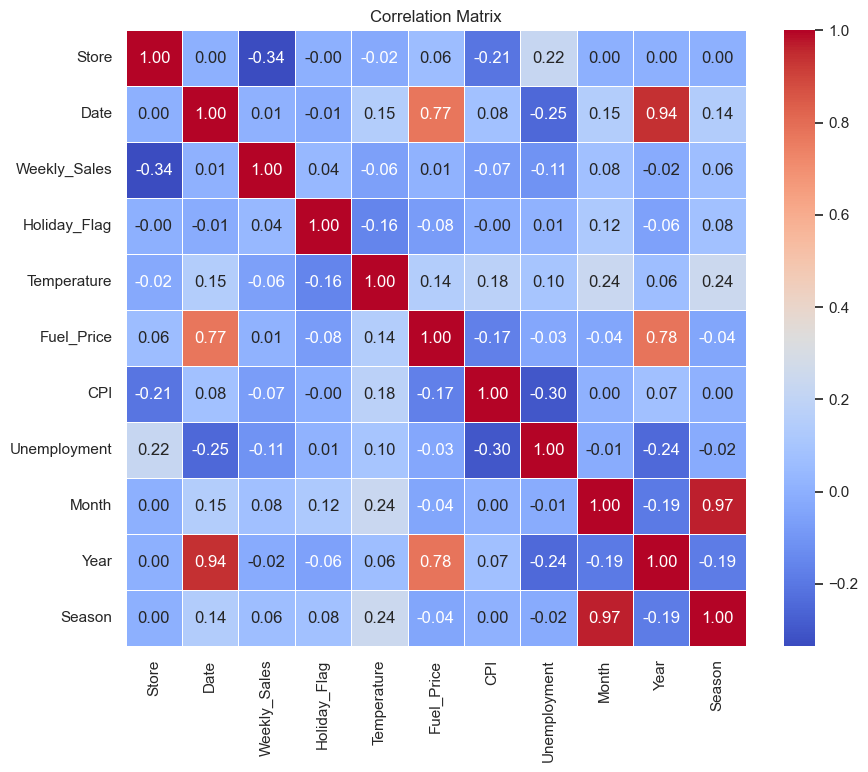

In [ ]:
# Calculate the correlation matrix among the features
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Preparing data

One hot encodes the 'Store ID' column, extracts the month and season from the 'Date' column and drops the 'Date' column. Potentially adds the 'Year' column as an input feature.

Splits the data into training and testing sets.

In [ ]:
# Set to true if you want to include the year as an input feature
include_year = True

In [ ]:
from sklearn.model_selection import train_test_split
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Convert the date column to datetime


df['Month'] = df['Date'].dt.month # Extract the month of each date
df['Year'] = df['Date'].dt.year # Extract the year of each date
df['Season'] = (df['Month']-1) // 3 + 1 # Compute the season of each date

df_final = df
# One-hot encode the store column
df_final = pd.get_dummies(df_final, columns=['Store'], drop_first=True)
if include_year:
  # One-hot encode the year column
  df_final = pd.get_dummies(df_final, columns=['Year'], drop_first=True)
  df_final = df_final.drop(columns=['Date', 'Season', 'Month'])
else:
  df_final = df_final.drop(columns=['Date', 'Season', 'Month', 'Year'])

# Split the data into training and testing sets
df_train, df_test, months_train, months_test, seasons_train, seasons_test = train_test_split(df_final, df['Month'], df['Season'], test_size=0.25, random_state=42)

## SVM definition
The model is defined as a pipeline composed of a normalization step and a Support Vector Machine classifier using the radial basis function kernel.

The best parameters for the SVM are found using a grid search with cross-validation.

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
  StandardScaler(),
  SVC(kernel='rbf', class_weight='balanced')
)
param_grid = {'svc__C': [0.1, 1, 100, 1000, 100000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 3)

### Training the model (seasons)

Finds the best parameters for the SVM using a grid search with cross-validation and trains the model using the 'Season' column as the target.

In [ ]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.447 total time=   0.9s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.520 total time=   0.8s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.487 total time=   0.8s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.504 total time=   0.8s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.513 total time=   0.8s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.370 total time=   0.8s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.396 total time=   0.8s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.406 total time=   0.8s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.410 total time=   0.8s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.417 total time=   0.8s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.539 total time=   0.8s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

In [ ]:
print(grid.best_params_)

### Model evaluation and results (seasons)

Plots the confusion matrix and the classification report for the model trained on the 'Season' column.

              precision    recall  f1-score   support

           1       0.91      0.95      0.93       354
           2       0.93      0.84      0.88       446
           3       0.86      0.94      0.90       454
           4       0.94      0.90      0.92       355

    accuracy                           0.91      1609
   macro avg       0.91      0.91      0.91      1609
weighted avg       0.91      0.91      0.91      1609



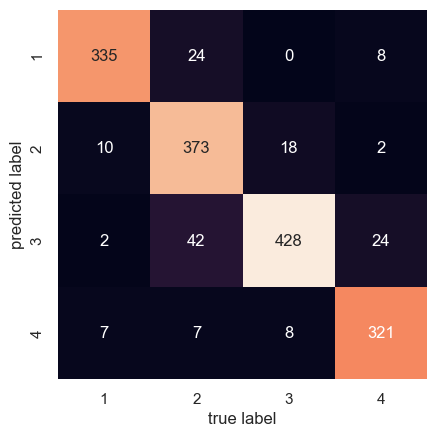

In [14]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Training the model (months)

In [ ]:
grid.fit(df_train, months_train)
model = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.088 total time=   1.0s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   1.0s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   1.0s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.084 total time=   1.0s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.097 total time=   1.0s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.089 total time=   1.0s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.055 total time=   1.0s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.055 total time=   1.0s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.084 total time=   1.0s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.097 total time=   1.0s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.173 total time=   1.0s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

In [1]:
print(grid.best_params_)

NameError: name 'grid' is not defined

### Model evaluation and results (months)

Plots the confusion matrix and the classification report for the model trained on the 'Month' column.

              precision    recall  f1-score   support

           1       0.92      0.91      0.92        89
           2       0.83      0.90      0.86       130
           3       0.69      0.76      0.72       135
           4       0.68      0.65      0.67       154
           5       0.63      0.68      0.65       133
           6       0.62      0.60      0.61       159
           7       0.59      0.69      0.64       162
           8       0.62      0.59      0.60       147
           9       0.75      0.73      0.74       145
          10       0.80      0.67      0.73       148
          11       0.63      0.61      0.62        97
          12       0.81      0.78      0.80       110

    accuracy                           0.70      1609
   macro avg       0.72      0.71      0.71      1609
weighted avg       0.71      0.70      0.70      1609



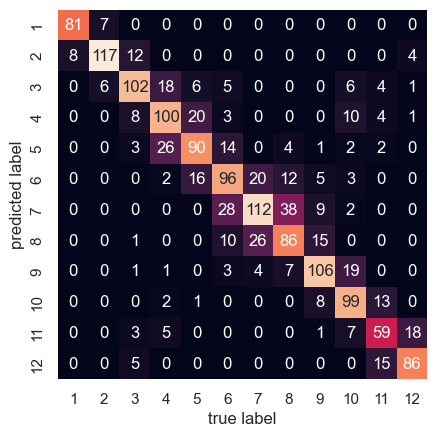

In [16]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))